# SATURDAY - TW INDIVIDUAL BIDDING STRATEGY

- Do the exponential afterwards

### SETUP

In [9]:
import time
beginning_time = time.time()

import sys
sys.path.append("../Code/")
from utils import performance

import os
DATA_DIR = os.path.join('..', 'Data')

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns

start = time.time()

def timtime():
    print(">",int((time.time()- start)//60), "minutes elapsed")

#----------------------------------------------------#    
    
train_X = pd.concat([pd.read_pickle(os.path.join(DATA_DIR, 'train_X_1')), 
                     pd.read_pickle(os.path.join(DATA_DIR, 'train_X_2'))])
train_y = pd.read_pickle(os.path.join(DATA_DIR, 'train_y'))
valid_X = pd.read_pickle(os.path.join(DATA_DIR, 'valid_X'))
valid_y = pd.read_pickle(os.path.join(DATA_DIR, 'valid_y'))

test_X = pd.read_pickle(os.path.join(DATA_DIR, 'test_X'))

### LOAD MODELS

_Using Logistic Regression as CTR predictor_

In [10]:
import pickle

GMM_filename = "../Models/SatGMM4"
with open(GMM_filename, 'rb') as file:
    GMM = pickle.load(file)
    

dist_pred_filename = "../Models/SatXGDistPred2"
with open(dist_pred_filename, 'rb') as file:
    dp = pickle.load(file)
    

ctr_pred_filename = "../Models/clf3.pkl"
with open(ctr_pred_filename, 'rb') as file:
    ctr = pickle.load(file)

### Investigate the market price distributions

In [11]:
from scipy.stats import norm

In [12]:
d1 = {"mu":GMM.means_[0][0], "sig":GMM.covariances_[0][0][0]}
d2 = {"mu":GMM.means_[1][0], "sig":GMM.covariances_[1][0][0]}
d3 = {"mu":GMM.means_[2][0], "sig":GMM.covariances_[2][0][0]}
d4 = {"mu":GMM.means_[3][0], "sig":GMM.covariances_[3][0][0]}

In [13]:
base_prices = []
for p in [pp1,pp2,pp3,pp4]:
    base_prices.append(np.max(np.expm1(p)))    
print(base_prices)

[97.500043508853423, 21.779086415373719, 38.022667032381108, 241.60718474562606]


In [14]:
new_base_prices = [98, 100, 100, 240]

In [15]:
from scipy.sparse import csr_matrix
train_X = csr_matrix(train_X) 
valid_X = csr_matrix(valid_X)
valid_distributions = dp.predict(valid_X)

In [16]:
N = np.shape(valid_X)[0]
valid_base_prices = np.zeros(N)
for i in range(N):
    valid_base_prices[i] = base_prices[valid_distributions[i]]

In [25]:
from utils import new_performance

### Make predictions - - - - - XGBOOST

In [34]:
# TODO #
ctr_pred_filename = "../Models/tim_xgb_click.pkl"
with open(ctr_pred_filename, 'rb') as file:
    ctr2 = pickle.load(file)

In [35]:
valid_ctr_prob_2 = ctr2.predict(valid_X)

In [43]:
np.sum(valid_base_prices*np.exp(valid_ctr_prob_2)>valid_y.payprice)/N

0.80864357983055035

In [ ]:
valid_base_prices

In [58]:
N = valid_X.shape[0]
valid_means = np.zeros(N)
for i in range(N):
    valid_means[i] = GMM.means_[valid_distributions[i],0]

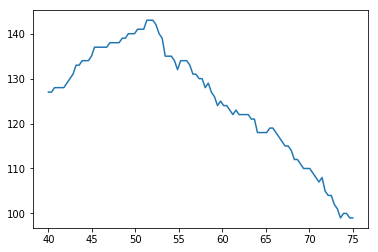

Best number of clicks: 143.0
Best base bid: 51.3131313131


In [65]:
QQ = valid_ctr_prob*valid_means

min_alpha = 40
max_alpha = 75
n_alphas = 100
alphas = np.linspace(min_alpha, max_alpha, n_alphas)

clicks = np.zeros_like(alphas)

for i, a in zip(range(n_alphas), alphas):
    bids = a*QQ
    _, c, _, _, _, _, _ = new_performance(bids, valid_y, verbose=False)
    clicks[i] = c
    
#### plot ####
plt.plot(alphas, clicks)
plt.show()

# best result
print("Best number of clicks:", np.max(clicks))
print("Best base bid:", alphas[np.argmax(clicks)])

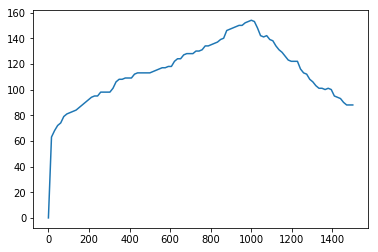

Best number of clicks: 154.0
Best base bid: 1000.0


In [100]:
QQ = valid_ctr_prob_2*np.expm1(valid_means)

min_alpha = 0
max_alpha = 1500
n_alphas = 100
alphas = np.linspace(min_alpha, max_alpha, n_alphas)

clicks = np.zeros_like(alphas)

for i, a in zip(range(n_alphas), alphas):
    bids = a*QQ
    _, c, _, _, _, _, _ = new_performance(bids, valid_y, verbose=False)
    clicks[i] = c
    
#### plot ####
plt.plot(alphas, clicks)
plt.show()

# best result
print("Best number of clicks:", np.max(clicks))
print("Best base bid:", alphas[np.argmax(clicks)])

In [70]:
new_performance(alphas[np.argmax(clicks)]*QQ, valid_y)

               CTR: (0.1051)%
        num_clicks: 159
             spend: 6135251 (98.16)%
              aCPM: 20.1867269886
              aCPC: 38.5864842767
num_in_budget_wins: 151317
 ads_within_budget: 303925


(0.10507742025020322,
 159,
 6135251,
 20.186726988566257,
 38.586484276729564,
 151317,
 303925)

In [76]:
kappa = 300

np.sum(kappa*valid_ctr_prob_2 > valid_ctr_prob)/np.sum(valid_ctr_prob==valid_ctr_prob)

0.51467960845603355

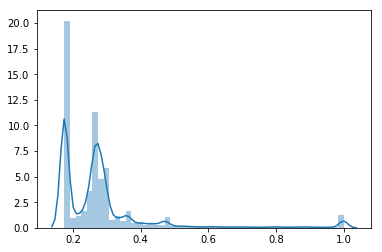

In [78]:
v = kappa*valid_ctr_prob_2
v[v>=1]=1
sns.distplot(v)
plt.show()

In [81]:
np.sum(v > valid_ctr_prob)/np.sum(valid_ctr_prob==valid_ctr_prob)

0.51467960845603355

In [88]:
J = np.max([v, valid_ctr_prob],axis=0)

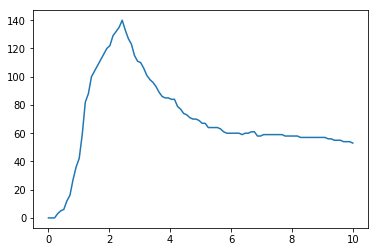

Best number of clicks: 140.0
Best base bid: 2.42424242424


In [96]:
QQ = J*np.expm1(valid_means)

min_alpha = 0
max_alpha = 10
n_alphas = 100
alphas = np.linspace(min_alpha, max_alpha, n_alphas)

clicks = np.zeros_like(alphas)

for i, a in zip(range(n_alphas), alphas):
    bids = a*QQ
    _, c, _, _, _, _, _ = new_performance(bids, valid_y, verbose=False)
    clicks[i] = c
    
#### plot ####
plt.plot(alphas, clicks)
plt.show()

# best result
print("Best number of clicks:", np.max(clicks))
print("Best base bid:", alphas[np.argmax(clicks)])